In [1]:
# Author: Morpheus Hsieh
# Ref: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

from __future__ import print_function, division  

import os, sys
import copy
import matplotlib.pyplot as plt
import numpy as np
import shutil
import time
import zipfile


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms

plt.ion()   # interactive mode

ProcessedPath = r'D:\GitWork\ants_and_bees\processed'

In [2]:
def decompressImages(procPath, zipAbspath):
    with zipfile.ZipFile(zipAbspath, 'r') as zip_ref:
        zip_ref.extractall(procPath)
        data_path = os.path.join(procPath, 'hymenoptera_data')
        
        list_dir = os.listdir(data_path)
        for sub_dir in list_dir:
            move_path = os.path.join(data_path, sub_dir)
            print(move_path)
            shutil.move(move_path, ProcPath)
        shutil.rmtree(data_path)
    return

RawPath  = r'D:\GitWork\ants_and_bees\raw'
RawFname = 'hymenoptera_data.zip'
ZipAbspath = os.path.join(RawPath, RawFname)

isExist = os.path.exists(ProcessedPath)
print('{} exist? {}'.format(ProcessedPath, isExist))
if not isExist: 
    decompressImages(ProcessedPath, ZipAbspath)        

D:\GitWork\ants_and_bees\processed exist? True


In [3]:
# ProcessedPath = r'D:\GitWork\ants_and_bees\processed'

normalize = transforms.Normalize(
    mean = [0.485, 0.456, 0.406],
    std  = [0.229, 0.224, 0.225]
)

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])
}

image_datasets = {
    x: datasets.ImageFolder(os.path.join(ProcessedPath, x), data_transforms[x])
    for x in ['train', 'valid']
}

trainSet = image_datasets['train']
validSet = image_datasets['valid']

class_names = trainSet.classes
print('classes: ', class_names)

class_indexes = trainSet.class_to_idx
print('class to index: ', class_indexes)

print()
print('size: ', len(trainSet))

trainX, trainY = trainSet[0]
print('\nimage:')
print(trainX)
print('label:', trainY)

classes:  ['ants', 'bees']
class to index:  {'ants': 0, 'bees': 1}

size:  244

image:
tensor([[[-0.7479, -0.7479, -0.7650,  ..., -0.6623, -0.6794, -0.6623],
         [-0.7479, -0.7650, -0.7822,  ..., -0.6794, -0.6965, -0.6623],
         [-0.7308, -0.7822, -0.7993,  ..., -0.6623, -0.6623, -0.6623],
         ...,
         [-0.6794, -0.6623, -0.6623,  ..., -0.3198, -0.4226, -0.3369],
         [-0.6794, -0.6794, -0.6794,  ..., -0.4054, -0.5596, -0.4397],
         [-0.6794, -0.6623, -0.6623,  ..., -0.5767, -0.5938, -0.5767]],

        [[ 0.6078,  0.6078,  0.5903,  ...,  0.6429,  0.6254,  0.6429],
         [ 0.6078,  0.5903,  0.5728,  ...,  0.6254,  0.6078,  0.6429],
         [ 0.6254,  0.5728,  0.5553,  ...,  0.6429,  0.6429,  0.6429],
         ...,
         [ 0.6954,  0.6954,  0.7129,  ...,  0.5203,  0.4678,  0.5728],
         [ 0.7129,  0.7129,  0.6954,  ...,  0.7654,  0.6429,  0.7304],
         [ 0.7129,  0.7304,  0.7129,  ...,  0.6779,  0.6604,  0.6429]],

        [[ 2.2566,  2.2566,  

In [4]:
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=4, shuffle=True, num_workers=4
    ) for x in ['train', 'valid']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
print(dataset_sizes)

show_size = 10
for i, data in enumerate(image_datasets['train']):
    if i >= show_size: break
    print('\ni:',i)
    image, label = data
    print('image:', image)
    print('label:', label)


{'train': 244, 'valid': 153}

i: 0
image: tensor([[[-0.7650, -0.7822, -0.7650,  ..., -0.7308, -0.7308, -0.7137],
         [-0.7822, -0.7993, -0.7822,  ..., -0.7308, -0.7308, -0.7308],
         [-0.7993, -0.7993, -0.7993,  ..., -0.7137, -0.6965, -0.6965],
         ...,
         [-0.6452, -0.6452, -0.6623,  ..., -0.6109, -0.6281, -0.6109],
         [-0.6452, -0.6452, -0.6452,  ..., -0.6109, -0.6281, -0.6281],
         [-0.6452, -0.6452, -0.6452,  ..., -0.6109, -0.6281, -0.6281]],

        [[ 0.5903,  0.5728,  0.5903,  ...,  0.6254,  0.6254,  0.6429],
         [ 0.5728,  0.5553,  0.5728,  ...,  0.6254,  0.6254,  0.6254],
         [ 0.5553,  0.5553,  0.5553,  ...,  0.6429,  0.6604,  0.6604],
         ...,
         [ 0.7129,  0.7129,  0.7304,  ...,  0.7829,  0.7654,  0.7479],
         [ 0.7304,  0.7129,  0.7129,  ...,  0.7479,  0.7479,  0.7304],
         [ 0.7304,  0.7129,  0.7129,  ...,  0.7479,  0.7304,  0.7304]],

        [[ 2.2391,  2.2217,  2.2391,  ...,  2.2740,  2.2740,  2.2914],
   

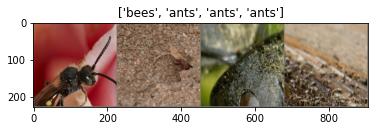

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp  = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp  = std * inp + mean
    inp  = np.clip(inp, 0, 1)
    plt.imshow(inp)
    
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
print(inputs.shape)
# print(inputs)
print(classes)

torch.Size([4, 3, 224, 224])
tensor([1, 0, 0, 0])


In [7]:
use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")
print(device)

cuda:0


In [8]:
# Training the model

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 30)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
# Finetuning the convnet

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [10]:
# Train and evaluate

model_ft = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25
)

Epoch 0/24
------------------------------
train Loss: 0.5623 Acc: 0.7049
valid Loss: 0.3078 Acc: 0.8824

Epoch 1/24
------------------------------
train Loss: 0.6280 Acc: 0.7582
valid Loss: 0.3078 Acc: 0.8758

Epoch 2/24
------------------------------
train Loss: 0.6193 Acc: 0.7254
valid Loss: 0.5866 Acc: 0.7778

Epoch 3/24
------------------------------
train Loss: 0.5492 Acc: 0.7787
valid Loss: 0.7553 Acc: 0.7712

Epoch 4/24
------------------------------
train Loss: 0.7559 Acc: 0.7746
valid Loss: 1.7304 Acc: 0.6732

Epoch 5/24
------------------------------
train Loss: 0.9418 Acc: 0.7295
valid Loss: 0.4305 Acc: 0.8824

Epoch 6/24
------------------------------
train Loss: 0.5818 Acc: 0.7582
valid Loss: 0.2208 Acc: 0.9281

Epoch 7/24
------------------------------
train Loss: 0.3509 Acc: 0.8730
valid Loss: 0.2777 Acc: 0.9020

Epoch 8/24
------------------------------
train Loss: 0.3641 Acc: 0.8361
valid Loss: 0.2070 Acc: 0.9346

Epoch 9/24
------------------------------
train Loss: 0

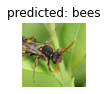

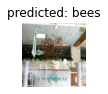

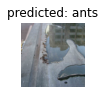

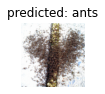

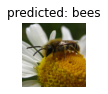

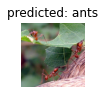

In [11]:
# Visualizing the model predictions

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model_ft)        